# Utilisation de 3 algorithmes pour une prédiction de prix.

Dans ce Notebook, nous allons dans un premier temps préparer les données afin de n'avoir que les colonnes dont nous aurons besoin. Puis, dans un deuxième temps, nous ferons une recherche des meilleures features a utiliser pour nos algorithmes. La troisième partie de ce Notebook sera dédiée à l'application des trois algorithmes que nous avons choisi, à savoir:  
- Régression Linéaire  
- SG Boost  
- Random Forest  

Nous évaluerons et testerons les performances de nos modèles puis à l'aide d'un GridSearch nous affinerons notre choix sur un seul algorithme et les meilleurs paramètres afin de pouvoir déployer celui-ci sur une application Flask.

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from boruta import BorutaPy
import pickle

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, max_error


### Chargement du Dataset

In [2]:
def load_data(file_path):
    return pd.read_csv(file_path)

df = load_data('./Data/houses_Madrid_cleaned.csv')

### Début de la préparation des données

La fonction 'clean_data' va supprimer les colonnes qui ne nous serviront pas, supprimer les valeurs négatives de la colonne 'rent_price'

In [3]:
def clean_data(df, columns_to_drop):
    df_cleaned = df.drop(columns=columns_to_drop)
    
    if 'rent_price' in df_cleaned.columns:
        df_cleaned = df_cleaned[df_cleaned['rent_price'] >= 0]
    
    return df_cleaned

columns_to_drop = ["Unnamed: 0", "id", "title", "subtitle", "is_exact_address_hidden", 
                   "floor", "neighborhood_id", "is_rent_price_known", 
                   "is_buy_price_known", "has_fitted_wardrobes", "house_type_id", "operation"]

df_cleaned = clean_data(df, columns_to_drop)
print(df_cleaned.describe())

        sq_mt_built       n_rooms   n_bathrooms    rent_price     buy_price  \
count  19095.000000  19095.000000  19095.000000  19095.000000  1.909500e+04   
mean     112.039644      2.728201      1.744959   1344.759466  4.188081e+05   
std       71.571679      1.230129      0.930607    586.701733  2.975910e+05   
min       13.000000      0.000000      1.000000     18.000000  3.600000e+04   
25%       67.000000      2.000000      1.000000    851.000000  1.827600e+05   
50%       91.000000      3.000000      2.000000   1218.000000  3.200000e+05   
75%      133.000000      3.000000      2.000000   1781.000000  5.773210e+05   
max      847.000000     15.000000     14.000000   2517.000000  1.380000e+06   

       buy_price_by_area   PricePerSqM  
count       19095.000000  19018.000000  
mean         3743.271275   3600.242558  
std          1643.331047   1325.369333  
min           447.000000   1308.890000  
25%          2431.000000   2323.930000  
50%          3517.000000   3600.400000  
7

### Début de la recherche des meilleures features

Création d'une matrice de corrélation

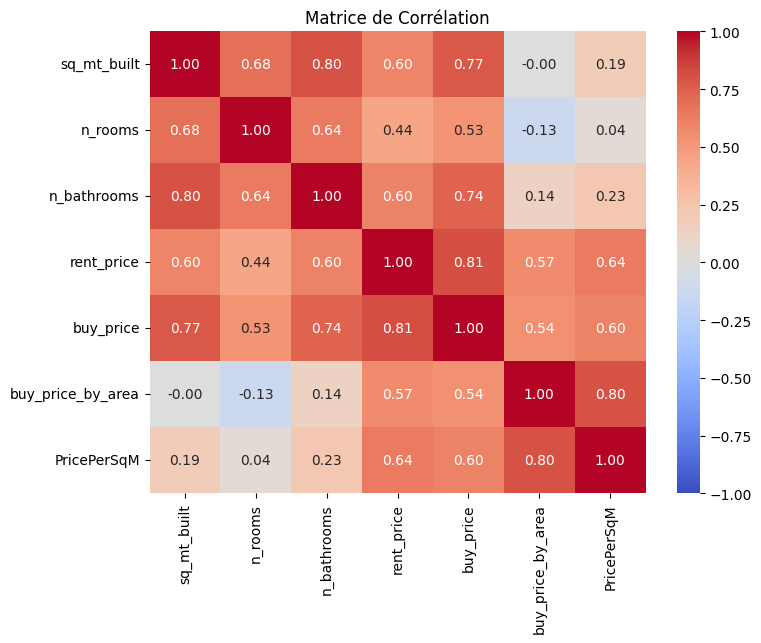

In [4]:
def plot_correlation_matrix(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
    plt.title('Matrice de Corrélation')
    plt.show()

df_numeric = df_cleaned.select_dtypes(include=['number'])
plot_correlation_matrix(df_numeric)

Préparation des features

In [5]:
def prepare_features_and_target(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return X, y

X, y = prepare_features_and_target(df_numeric, 'buy_price')

On gère les valeurs manquantes

In [6]:
def handle_missing_values(X):
    missing_values = X.isna().sum()
    print("Valeurs manquantes avant traitement :", missing_values[missing_values > 0])
    X_cleaned = X.dropna()
    print("Valeurs manquantes après suppression :", X_cleaned.isna().sum().sum())
    return X_cleaned

X = handle_missing_values(X)
y = y[X.index]

Valeurs manquantes avant traitement : PricePerSqM    77
dtype: int64
Valeurs manquantes après suppression : 0


Imputation de valeurs manquantes

In [7]:
def split_and_impute_data(X, y, test_size=0.3, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    imputer = SimpleImputer(strategy='median')
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_and_impute_data(X, y)

Sélection de features via SequentialFeatureSelector

In [8]:
def select_features_with_sfs(X_train, y_train, model):
    sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', cv=5)
    sfs.fit(X_train, y_train)
    selected_features = X_train.columns[sfs.get_support()]
    print("Caractéristiques sélectionnées par SFS :", selected_features)
    return selected_features

selected_features_sfs = select_features_with_sfs(X_train, y_train, LinearRegression())

Caractéristiques sélectionnées par SFS : Index(['sq_mt_built', 'rent_price', 'buy_price_by_area'], dtype='object')


Sélection de features via Boruta

In [9]:
def select_features_with_boruta(X_train, y_train):
    rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=0)
    boruta = BorutaPy(rf, n_estimators='auto', random_state=0)
    boruta.fit(X_train.values, y_train.values)
    selected_features = X_train.columns[boruta.support_]
    print("Caractéristiques sélectionnées par Boruta :", selected_features)
    return selected_features

selected_features_boruta = select_features_with_boruta(X_train, y_train)

Caractéristiques sélectionnées par Boruta : Index(['sq_mt_built', 'n_rooms', 'n_bathrooms', 'rent_price',
       'buy_price_by_area', 'PricePerSqM'],
      dtype='object')


Sélection de features via RandomForestRegressor

In [10]:
def feature_importance_with_rfr(X_train, y_train):
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=0)
    rf_regressor.fit(X_train, y_train)
    importance = rf_regressor.feature_importances_
    feature_importances = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)
    print("Importance des caractéristiques :", feature_importances)
    return feature_importances

feature_importances = feature_importance_with_rfr(X_train, y_train)

Importance des caractéristiques : rent_price           0.721205
sq_mt_built          0.212088
buy_price_by_area    0.061583
PricePerSqM          0.002832
n_bathrooms          0.001750
n_rooms              0.000542
dtype: float64


Application, test et évaluation de l'algorithme de Régression Linéaire.

In [11]:
def train_and_evaluate_linear_regression(X_train, X_test, y_train, y_test):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    y_pred_lr = lr.predict(X_test)
    
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    rmse_lr = np.sqrt(mse_lr)
    mape_lr = np.mean(np.abs((y_test - y_pred_lr) / y_test)) * 100
    evs_lr = explained_variance_score(y_test, y_pred_lr)
    max_err_lr = max_error(y_test, y_pred_lr)
    
    n = len(y_test)
    p = X_test.shape[1]
    adjusted_r2_lr = 1 - (1 - r2_lr) * (n - 1) / (n - p - 1)
    
    print("Régression Linéaire :")
    print(f"Mean Squared Error (MSE)           : {mse_lr}")
    print(f"Root Mean Squared Error (RMSE)     : {rmse_lr}")
    print(f"Mean Absolute Error (MAE)          : {mae_lr}")
    print(f"Mean Absolute Percentage Error (MAPE) : {mape_lr:.2f}%")
    print(f"R² Score                           : {r2_lr}")
    print(f"Adjusted R² Score                  : {adjusted_r2_lr}")
    print(f"Explained Variance Score (EVS)     : {evs_lr}")
    print(f"Max Error                          : {max_err_lr}")
    
    return lr

linear_regression_model = train_and_evaluate_linear_regression(X_train, X_test, y_train, y_test)

Régression Linéaire :
Mean Squared Error (MSE)           : 8314674088.521915
Root Mean Squared Error (RMSE)     : 91184.83475075182
Mean Absolute Error (MAE)          : 55581.98922971594
Mean Absolute Percentage Error (MAPE) : 17.29%
R² Score                           : 0.9066429412757282
Adjusted R² Score                  : 0.9065446534441182
Explained Variance Score (EVS)     : 0.9066930586170235
Max Error                          : 1073610.7242889225


#### Explications des résultats pour Régression Linéaire

Évaluation du Modèle de Régression Linéaire  

Pour évaluer les performances de notre modèle de régression linéaire, nous avons utilisé plusieurs métriques, dont voici les explications :  

<i><u>Mean Squared Error (MSE) :</u></i>  

MSE mesure la moyenne des carrés des erreurs, c’est-à-dire la différence moyenne au carré entre les valeurs prédites et les valeurs réelles. Une valeur plus faible indique un modèle avec de meilleures performances.  
Ici, le MSE est de 11 759 187 268.58.  
Ce nombre représente la somme des carrés des résidus moyens. Bien que cette valeur semble élevée, il faut la comparer avec l'échelle des prix de l'immobilier pour évaluer sa pertinence.  

<i><u>Root Mean Squared Error (RMSE) :</u></i>  

RMSE est la racine carrée du MSE, ce qui permet d’interpréter cette métrique dans la même unité que la variable cible (buy_price).
Le RMSE obtenu est de 108,439.79. Cela signifie que l'écart type moyen des prévisions de notre modèle par rapport aux prix réels est d'environ 108,439 euros. Un RMSE plus faible indique une meilleure précision.  

<i><u>Mean Absolute Error (MAE) :</u></i>  

MAE mesure l'erreur absolue moyenne entre les valeurs prédites et les valeurs réelles. Elle représente la moyenne des erreurs absolues.
Le MAE est de 65,657.97, ce qui signifie que, en moyenne, les prévisions de notre modèle diffèrent des prix réels d'environ 65,658 euros.  

<i><u>Mean Absolute Percentage Error (MAPE) :</u></i>  

MAPE est un pourcentage qui mesure l'erreur absolue moyenne relative par rapport aux valeurs réelles.
Le MAPE est de 19.10%, ce qui signifie que, en moyenne, les prévisions de notre modèle sont à environ 19.10% des prix réels. Un MAPE plus bas est indicatif d’un modèle plus précis.  

<i><u>R² Score :</u></i>  

R² Score ou coefficient de détermination représente la proportion de la variance dans la variable cible qui est expliquée par le modèle.
Ici, le R² est de 0.9065, ce qui signifie que 90.65% de la variance des prix immobiliers est expliquée par les variables sélectionnées dans notre modèle. Cela indique une très bonne qualité d’ajustement du modèle.  

<i><u>Adjusted R² Score :</u></i>  

R² ajusté est une version modifiée du R² qui tient compte du nombre de variables dans le modèle. Il pénalise les modèles qui incluent trop de variables non significatives.
L'Adjusted R² est de 0.9065, très proche du R² classique. Cela indique que les variables incluses dans le modèle sont pertinentes et contribuent de manière significative à expliquer la variance de la variable cible.  

<i><u>Explained Variance Score (EVS) :</u></i>  

EVS mesure la proportion de variance expliquée par le modèle, similaire au R², mais avec une évaluation légèrement différente des erreurs.
Le score EVS est de 0.9066, très proche du R², ce qui confirme que le modèle explique bien la variabilité des données.  

<i><u>Max Error :</u></i>  

Max Error représente la plus grande erreur absolue observée entre les prédictions du modèle et les valeurs réelles.
La valeur du Max Error est de 1,237,042.89. Cela signifie que la plus grande différence entre un prix prédit et un prix réel est d'environ 1,237,042 euros. Bien que la majorité des erreurs soient plus faibles, cela montre que le modèle peut parfois faire des erreurs importantes pour certains biens.

### Sauvegarde du modèle pour Flask

In [12]:
def save_model(model, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(model, file)

save_model(linear_regression_model, './flask_app/models/linear_regression_model.pkl')